# Assignment 2
## Question 1
Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [1]:
import pandas as pd

data_orders = pd.read_csv("./datasets/data_orders.csv")
data_offers = pd.read_csv("./datasets/data_offers.csv")
data_merged= pd.merge(data_orders, data_offers, on='order_gk', how='left')

In [2]:
print("Number of rows in data_orders: ", data_orders.shape[0])
print("Number of rows in data_offers: ", data_offers.shape[0])
print("Number of rows in data_merged: ", data_merged.shape[0])

Number of rows in data_orders:  10716
Number of rows in data_offers:  334363
Number of rows in data_merged:  34374


In [3]:
import numpy as np

data=data_orders.copy()
conditions = [
    (data['is_driver_assigned_key'] == 1) & (data['order_status_key'] == 4),
    (data['is_driver_assigned_key'] == 1) & (data['order_status_key'] == 9),
    (data['is_driver_assigned_key'] == 0) & (data['order_status_key'] == 4),
    (data['is_driver_assigned_key'] == 0) & (data['order_status_key'] == 9)
]

failure_reasons = [
    'Client cancelled after driver assigned',
    'System rejected after driver assigned',
    'Client cancelled before driver assigned',
    'System rejected before driver assigned'
]

data['failure_reason'] = np.select(conditions, failure_reasons, default='Unknown')

failure_counts = data['failure_reason'].value_counts()

print(failure_counts)

failure_reason
Client cancelled before driver assigned    4496
System rejected before driver assigned     3406
Client cancelled after driver assigned     2811
System rejected after driver assigned         3
Name: count, dtype: int64


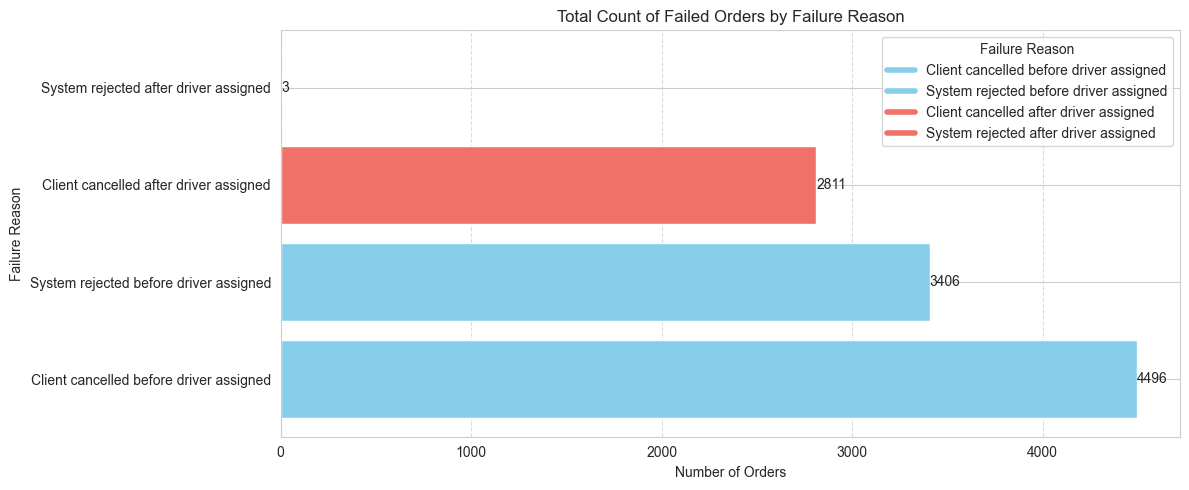

In [4]:
import matplotlib.pyplot as plt

colors = ['skyblue', 'skyblue', '#F07167', '#F07167']

plt.figure(figsize=(12,5))
bars = plt.barh(failure_counts.index, failure_counts.values, color=[colors[i] for i in range(len(failure_counts))])

for bar in bars:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height() / 2.0, int(xval), ha='left', va='center')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[i], lw=4) for i in range(len(colors))]
plt.legend(custom_lines, failure_counts.index, title='Failure Reason')

plt.title('Total Count of Failed Orders by Failure Reason')
plt.xlabel('Number of Orders')
plt.ylabel('Failure Reason')

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('./graphs/total_failed_orders_by_reason.png')
plt.show()

## Question2
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [5]:
data['order_datetime'].head(5)

0    18:08:07
1    20:57:32
2    12:07:50
3    13:50:20
4    21:24:45
Name: order_datetime, dtype: object

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


data['order_datetime'] = pd.to_datetime(data['order_datetime'], errors='coerce')
data = data.dropna(subset=['order_datetime'])
data['order_hour'] = data['order_datetime'].dt.hour

hourly_failure_counts = data.groupby(['order_hour', 'failure_reason']).size().unstack(fill_value=0)

In [7]:
colors = {
    'Client cancelled after driver assigned': 'red',
    'Client cancelled before driver assigned': 'orange',
    'System rejected after driver assigned': '#B6465F',
    'System rejected before driver assigned': '#EBD4CB'
}

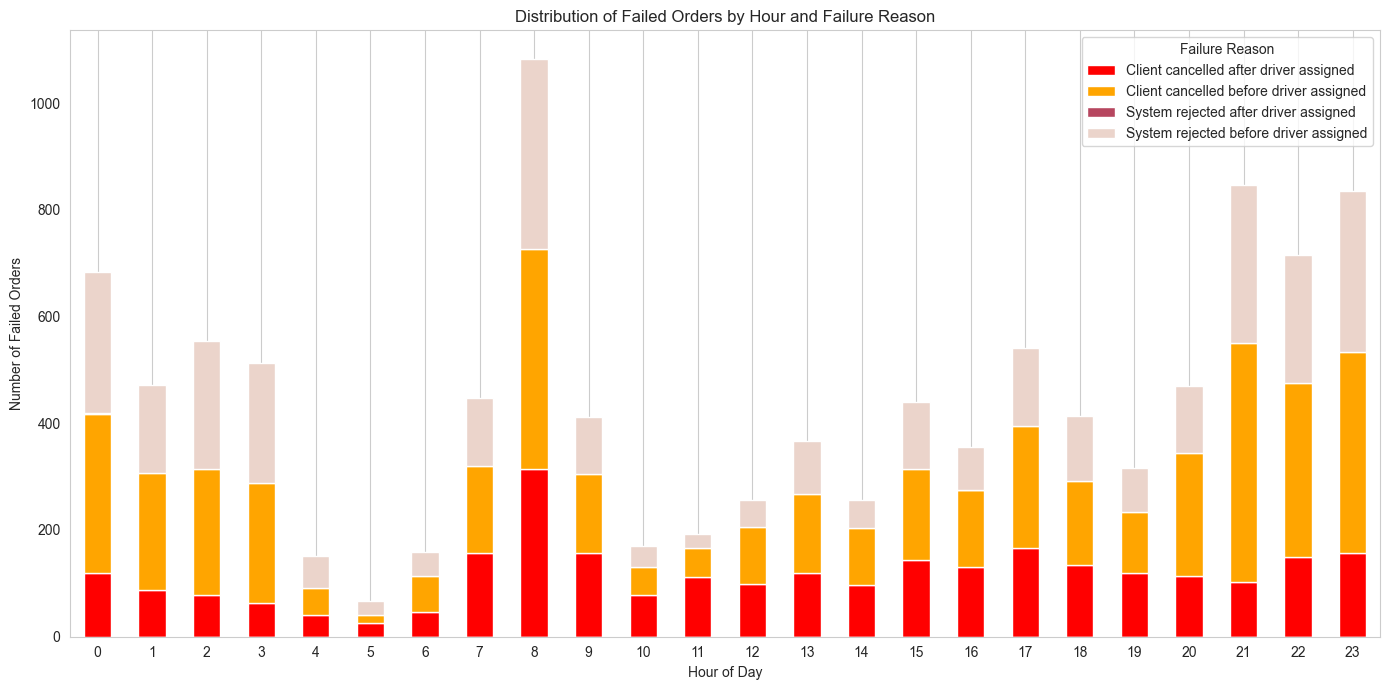

In [8]:
color_list = [colors[reason] for reason in hourly_failure_counts.columns]

hourly_failure_counts.plot(kind='bar', stacked=True, figsize=(14, 7), color=color_list)
plt.title('Distribution of Failed Orders by Hour and Failure Reason')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Failed Orders')
plt.legend(title='Failure Reason')
plt.xticks(range(24), rotation=0) 
plt.grid(axis='y')
plt.tight_layout() 
plt.savefig('./graphs/hourly_distribution_failed_orders.png')
plt.show()

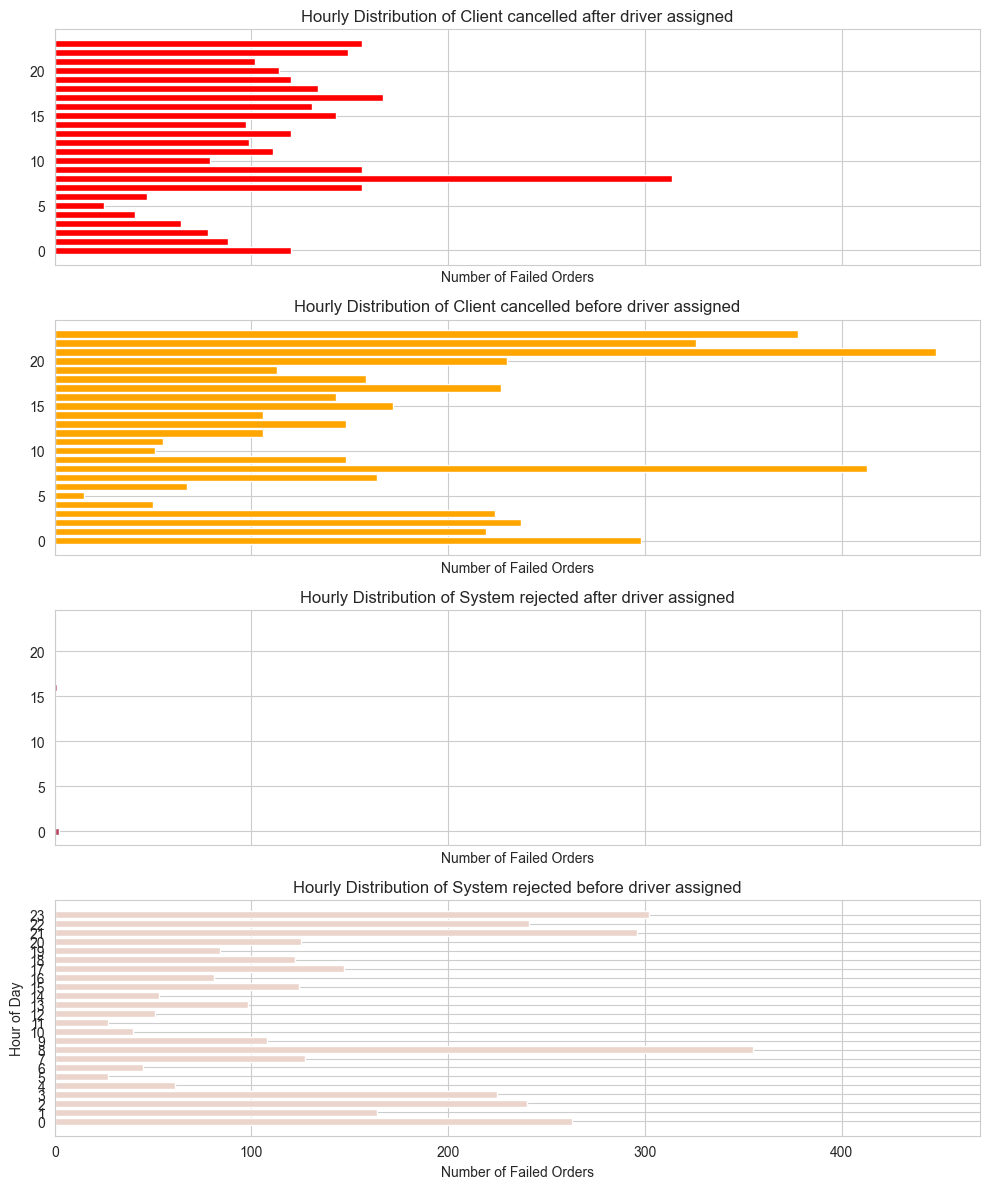

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

for i, (reason, color) in enumerate(colors.items()):
    axs[i].barh(hourly_failure_counts.index, hourly_failure_counts[reason], color=color)
    axs[i].set_title(f'Hourly Distribution of {reason}')
    axs[i].set_xlabel('Number of Failed Orders')
    
# 设置共享的y轴标签
axs[3].set_ylabel('Hour of Day')
plt.yticks(range(24))
plt.tight_layout()
plt.savefig('./graphs/hourly_distribution_failed_orders_subgraphs.png')
plt.show()


## Question 3
Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

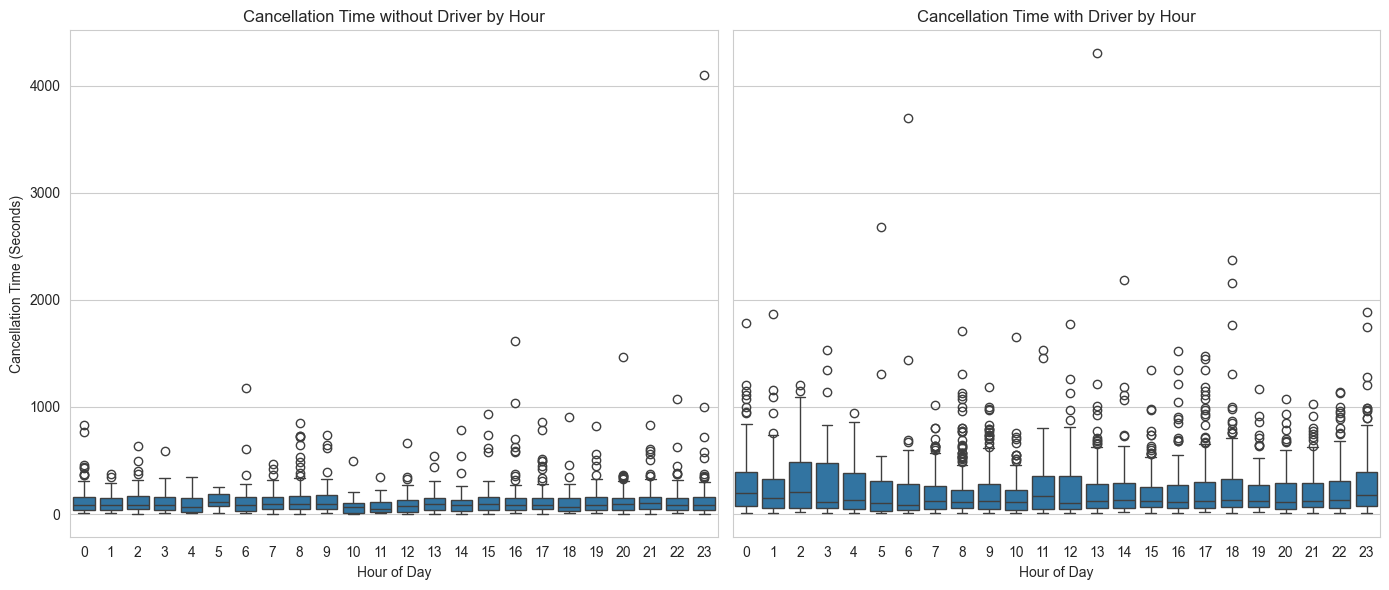

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

data['order_hour'] = data['order_datetime'].dt.hour

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# 无司机时的取消时间箱线图
data_no_driver = data[data['is_driver_assigned_key'] == 0]
sns.boxplot(x='order_hour', y='cancellations_time_in_seconds', data=data_no_driver, ax=axes[0])
axes[0].set_title('Cancellation Time without Driver by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Cancellation Time (Seconds)')

# 有司机时的取消时间箱线图
data_with_driver = data[data['is_driver_assigned_key'] == 1]
sns.boxplot(x='order_hour', y='cancellations_time_in_seconds', data=data_with_driver, ax=axes[1])
axes[1].set_title('Cancellation Time with Driver by Hour')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')  # 使用空字符串作为ylabel，因为左边的图已经包含了它

plt.tight_layout()
plt.savefig('./graphs/cancellation_time_by_hour_boxplot.png')
plt.show()


Length of list 1: 24
Length of list 2: 24
Length of list 3: 24


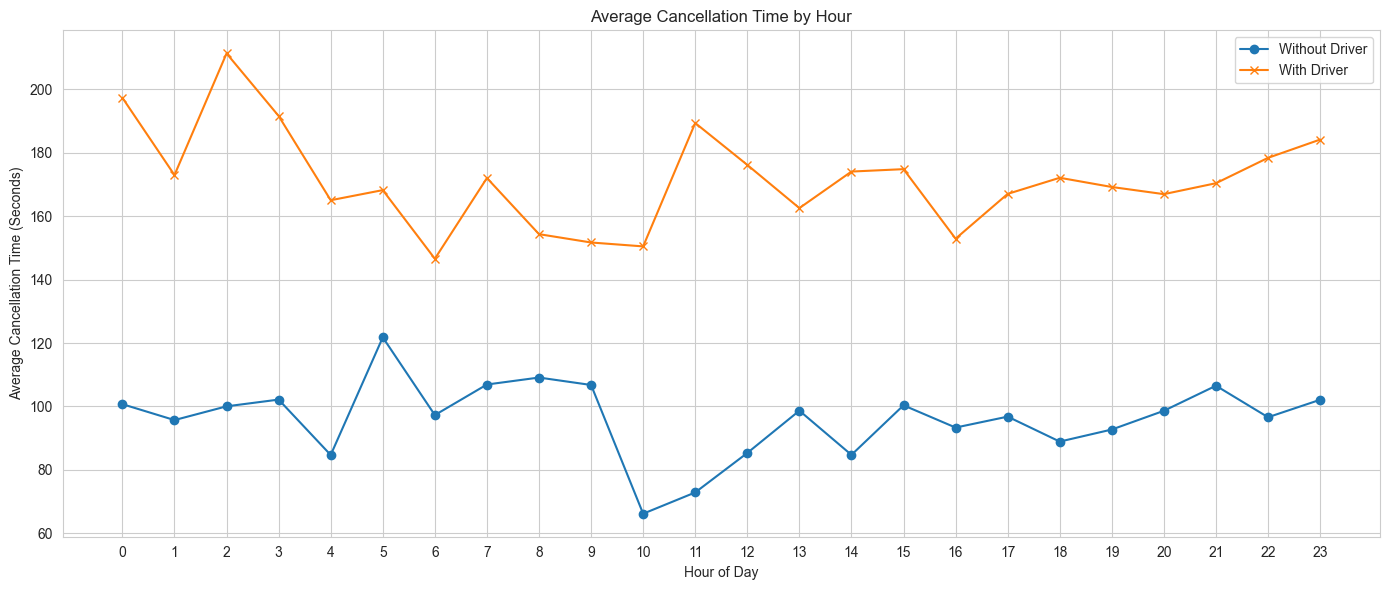

In [11]:
import matplotlib.pyplot as plt

data_no_driver = data[data['is_driver_assigned_key'] == 0]
data_with_driver = data[data['is_driver_assigned_key'] == 1]

def calculate_avg_time_and_outliers(data, time_column):
    
    Q1 = data[time_column].quantile(0.25)
    Q3 = data[time_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[time_column] < lower_bound) | (data[time_column] > upper_bound)]
    outliers_count_by_hour = outliers.groupby('order_hour').size()

    data_filtered = data[(data[time_column] >= lower_bound) & (data[time_column] <= upper_bound)]
    avg_time_by_hour = data_filtered.groupby('order_hour')[time_column].mean()
    
    return avg_time_by_hour, outliers_count_by_hour

avg_time_no_driver, outliers_no_driver = calculate_avg_time_and_outliers(data_no_driver, 'cancellations_time_in_seconds')

avg_time_with_driver, outliers_with_driver = calculate_avg_time_and_outliers(data_with_driver, 'cancellations_time_in_seconds')

import pandas as pd

outliers_df = pd.DataFrame({
    'Hour': range(24),
    'Outliers Without Driver': outliers_no_driver.reindex(range(24), fill_value=0).values,
    'Outliers With Driver': outliers_with_driver.reindex(range(24), fill_value=0).values
})

outliers_df.set_index('Hour', inplace=True)

lists = [outliers_df.index, outliers_df['Outliers Without Driver'], outliers_df['Outliers With Driver']]

for i, lst in enumerate(lists):
    print(f"Length of list {i+1}: {len(lst)}")


plt.figure(figsize=(14, 6))
plt.plot(avg_time_no_driver.index, avg_time_no_driver.values, label='Without Driver', marker='o')
plt.plot(avg_time_with_driver.index, avg_time_with_driver.values, label='With Driver', marker='x')

plt.title('Average Cancellation Time by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Cancellation Time (Seconds)')
plt.legend()
plt.grid(True)
plt.xticks(range(24))
plt.tight_layout()
plt.savefig('./graphs/average_cancellation_time_by_hour.png')
plt.show()


## Question 4
Plot the distribution of average ETA by hours. How can this plot be explained?

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

data['order_datetime'] = pd.to_datetime(data['order_datetime'])
data['order_hour'] = data['order_datetime'].dt.hour

average_eta_by_hour = data.groupby('order_hour')['m_order_eta'].mean()


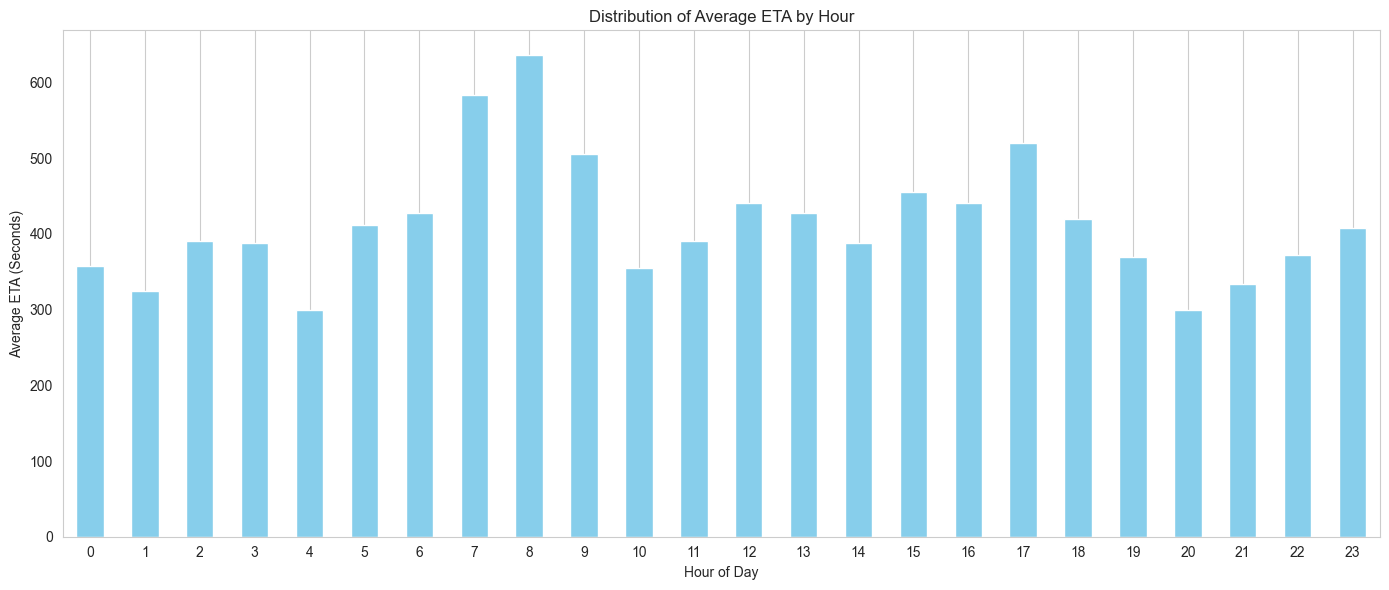

In [13]:
plt.figure(figsize=(14, 6))
average_eta_by_hour.plot(kind='bar', color='skyblue')
plt.title('Distribution of Average ETA by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average ETA (Seconds)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./graphs/average_eta_by_hour.png')
plt.show()

## Question 5
(BONUS) Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [14]:
import folium
import h3
import branca.colormap as cm

def lat_lng_to_h3(lat, lng, hex_size=8):
    return h3.geo_to_h3(lat, lng, hex_size)

data['hex'] = data.apply(
    lambda x: lat_lng_to_h3(x['origin_latitude'], x['origin_longitude']), axis=1)

failed_orders = data[data['order_status_key'].isin([4, 9])]
order_counts_per_hex = failed_orders['hex'].value_counts()

min_count = order_counts_per_hex.min()
max_count = order_counts_per_hex.max()

color_scale = cm.LinearColormap(
    colors=['#67B26F', '#F79D5C', '#F52F57', '#A20021'],
    vmin=min_count,
    vmax=max_count
)

color_scale = color_scale.to_step(n=5)
color_scale.caption = 'Number of Failed Orders'

median_latitude = data['origin_latitude'].median()
median_longitude = data['origin_longitude'].median()

map_with_hexes = folium.Map(location=[median_latitude, median_longitude], zoom_start=12)

for hex_id, count in order_counts_per_hex.items():
    hex_boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    hex_boundary = [(coords[1], coords[0]) for coords in hex_boundary]
    
    hex_color = color_scale(count)
    
    folium.Polygon(
        locations=hex_boundary,
        color=hex_color,  # The outline color of the hexagon
        fill_color=hex_color,  # The fill color of the hexagon
        fill_opacity=0.7,  # The fill opacity of the hexagon
        weight=1.1,  # The line weight of the hexagon
    ).add_to(map_with_hexes)

color_scale.add_to(map_with_hexes)

map_with_hexes.save('map_with_hexes.html')
map_with_hexes